In [293]:
import glob

import pandas as pd
from tqdm import tqdm
# from rapidfuzz import process, fuzz
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import pyreadr
import icd10
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# # Load the disease dataset
# # df_diseases = pd.read_csv("../CTD/data/target_disease/sample_cor_99.csv")
# # df_diseases = pd.read_csv("../CTD/data/open_targets/sample_cor_99.csv
# with open('../CTD/data/open_targets/cor_matrix_95_nolit.csv', 'r') as f:
#     diseases = f.readline().strip().split(',')
# diseases = [d.replace("_", " ").lower() for d in diseases]

# # Load the ICD-10 dataset
# df_icd = pd.read_csv("data/DiagAll_Eng.csv")
# df_icd = df_icd.drop_duplicates(subset=["ShortDescription"])  # Ensure unique descriptions
# icd_dict = dict(zip(df_icd["ShortDescription"].str.lower(), df_icd["Code"]))
# icd_descriptions = set(icd_dict.keys())  # Convert to set for faster lookup

# def map_disease(disease_name):
#     # Check for exact match first
#     if disease_name in icd_descriptions:
#         return disease_name
    
#     # If no exact match, use faster fuzzy string matching
#     best_match = process.extractOne(disease_name, icd_descriptions, scorer=fuzz.WRatio)
#     return best_match[0] if best_match and best_match[1] > 60 else "UNKNOWN"

# # Use multithreading to speed up mapping (max 6 threads)
# with ThreadPoolExecutor(max_workers=6) as executor:
#     results = list(tqdm(executor.map(map_disease, diseases), total=len(diseases), desc="Mapping diseases to ICD-10 codes"))

# diseases_mapping = dict(zip(diseases, results))

# # Print each mapping on a new line
# for disease, icd in list(diseases_mapping.items())[:50]:
#     print(f"{disease}: {icd}")


In [221]:
# open_target_df = pd.read_csv('../CTD/data/open_targets/cor_matrix_95_nolit.csv')
# open_target_df = pd.read_csv('../CTD/data/target_disease/cor_matrix_99.csv.csv')
open_target_df = pd.read_csv('../CTD/data/open_targets/dis_dis_nolit.csv')
open_target_df.index = open_target_df.columns
open_target_df
# for col in open_target_df.columns:
#     if 'ementia' in col:
#         print(col)

,15q overgrowth syndrome,"17,20-lyase deficiency, isolated","17-alpha-hydroxylase/17,20-lyase deficiency, combined complete","17-alpha-hydroxylase/17,20-lyase deficiency, combined partial",2-3 finger syndactyly,2-3 toe syndactyly,2-aminoadipic 2-oxoadipic aciduria,2-hydroxyglutaric aciduria,2-methylbutyryl-CoA dehydrogenase deficiency,3-4 toe syndactyly,...,xeroderma pigmentosum group G,xeroderma pigmentosum variant type,xeroderma pigmentosum-Cockayne syndrome complex,xerosis and growth failure with immune and pulmonary dysfunction syndrome,xerostomia,young-onset Parkinson disease,zebra body myopathy,"zinc deficiency, transient neonatal",zygodactyly type 3,Åland Islands eye disease
15q overgrowth syndrome,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.281958,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
"17,20-lyase deficiency, isolated",0.0,0.000000,0.871953,0.847936,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
"17-alpha-hydroxylase/17,20-lyase deficiency, combined complete",0.0,0.871953,0.000000,0.847936,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
"17-alpha-hydroxylase/17,20-lyase deficiency, combined partial",0.0,0.847936,0.847936,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2-3 finger syndactyly,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.251987,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
young-onset Parkinson disease,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.257915,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
zebra body myopathy,0.0,0.000000,0.000000,0.000000,0.251987,0.0,0.0,0.0,0.0,0.0,...,0.285332,0.0,0.0,0.0,0.0,0.0,0.000000,0.274217,0.0,0.0
"zinc deficiency, transient neonatal",0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.274217,0.000000,0.0,0.0
zygodactyly type 3,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


In [222]:
# # Add one umbrella for all dementia related diseases
# # Identify columns/rows related to 'dementia' or 'alzheimer' (case-insensitive)
# disease_mask = open_target_df.columns.str.contains('dementia', case=False, regex=True)  # |alzheimer
# selected_diseases = open_target_df.columns[disease_mask]

# # Compute the mean correlation of the selected diseases with all diseases
# merged_row = open_target_df.loc[selected_diseases].mean()
# merged_col = open_target_df[selected_diseases].mean(axis=1)

# # Add the new row and column to the DataFrame
# open_target_df["Dementia in Alzheimer's disease"] = merged_col
# open_target_df.loc["Dementia in Alzheimer's disease"] = list(merged_row) + [0.0]  # correlation with itself
# open_target_df

# Map OpenTargets disease names to ICD10 codes

In [223]:
# Precompute disease embeddings
import torch
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util

# with open('../CTD/data/open_targets/cor_matrix_95_nolit.csv', 'r') as f:
#     diseases = f.readline().strip().split(',')
diseases = open_target_df.columns  #[d.replace("_", " ").lower() for d in open_target_df.columns]

# Load the ICD-10 dataset
df_icd = pd.read_csv("data/DiagAll_Eng.csv")
df_icd['ShortDescription'] = df_icd['ShortDescription'].replace(
    "Dementia in Alzheimer\'s disease", "Dementia"
)
df_icd = df_icd.drop_duplicates(subset=["ShortDescription"])  # Ensure unique descriptions
icd_dict = dict(zip(df_icd["ShortDescription"], df_icd["Code"]))
icd_descriptions = list(icd_dict.keys())
icd_codes = list(icd_dict.values())

# Load a pre-trained sentence transformer model
model = SentenceTransformer("NeuML/pubmedbert-base-embeddings")

print('Creating ICD10 embeddings...')
# Encode ICD-10 descriptions as embeddings without converting to tensor
icd_embeddings = model.encode(icd_descriptions, convert_to_tensor=False)

print('Precompute disease embeddings...')
disease_embeddings = {disease: model.encode(disease, convert_to_tensor=False) for disease in diseases}


Creating ICD10 embeddings...
Precompute disease embeddings...


In [224]:
def map_diseases(disease_name_1, disease_embedding, icd_dict, icd_descriptions, icd_codes, icd_embeddings):
#     disease_name_1_cleaned = disease_name_1.replace("_", " ").lower()
    
    # Check for exact match first
    if disease_name_1 in icd_dict:
        return disease_name_1
    
    # If no exact match, use semantic similarity
    disease_embedding_tensor = torch.tensor(disease_embedding)  # Ensure it's a tensor
    icd_embeddings_tensor = torch.tensor(icd_embeddings)  # Convert stored embeddings
    
    similarities = util.pytorch_cos_sim(disease_embedding_tensor, icd_embeddings_tensor)[0]
    best_match_idx = similarities.argmax().item()
    return icd_descriptions[best_match_idx] if similarities[best_match_idx] > 0.5 else "UNKNOWN"

# Map diseases to ICD-10 codes with progress tracking
diseases_mapping = {}
for disease in tqdm(diseases, desc="Mapping disease names to ICD-10"):
    diseases_mapping[disease] = map_diseases(disease, disease_embeddings[disease], icd_dict, icd_descriptions, icd_codes, icd_embeddings)

# Print a sample output
# Print each mapping on a new line
for disease, icd in list(diseases_mapping.items())[:50]:
    print(f"{disease}: {icd}")

Mapping disease names to ICD-10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13227/13227 [00:05<00:00, 2296.07it/s]

15q overgrowth syndrome: UNKNOWN
17,20-lyase deficiency, isolated: UNKNOWN
17-alpha-hydroxylase/17,20-lyase deficiency, combined complete: UNKNOWN
17-alpha-hydroxylase/17,20-lyase deficiency, combined partial: UNKNOWN
2-3 finger syndactyly: Acquired deformities of fingers and toes
2-3 toe syndactyly: Acquired deformities of fingers and toes
2-aminoadipic 2-oxoadipic aciduria: UNKNOWN
2-hydroxyglutaric aciduria: UNKNOWN
2-methylbutyryl-CoA dehydrogenase deficiency: Disorders of branched-chain amino-acid metabolism and fatty-acid metabolism
3-4 toe syndactyly: Acquired deformities of fingers and toes
3-M syndrome: UNKNOWN
3-Methylglutaric aciduria: Disorders of branched-chain amino-acid metabolism and fatty-acid metabolism
3-hydroxy-3-methylglutaric aciduria: UNKNOWN
3-hydroxy-3-methylglutaryl-CoA synthase deficiency: UNKNOWN
3-hydroxyacyl-CoA dehydrogenase deficiency: UNKNOWN
3-hydroxyisobutyric aciduria: UNKNOWN
3-hydroxyisobutyryl-CoA hydrolase deficiency: UNKNOWN
3-methylcrotonyl-CoA

In [225]:
# Assume open_target_df is your large adjacency matrix and diseases_mapping is your dictionary
# Filter columns based on diseases_mapping values that are not 'UNKNOWN'
print("Filtering columns based on valid diseases (not 'UNKNOWN')...")
valid_diseases = {k: v for k, v in diseases_mapping.items() if v != 'UNKNOWN'}

# Ensure only valid keys are used for filtering
valid_keys = set(valid_diseases.keys()) & set(open_target_df.columns)
print(f"Selecting {len(valid_keys)} valid diseases from the matrix...")
filtered_open_target_df = open_target_df.loc[list(valid_keys), list(valid_keys)]

# Rename only the columns and rows that exist in the mapping
rename_mapping = {k: v for k, v in valid_diseases.items() if k in filtered_open_target_df.columns}
print("Renaming rows and columns according to diseases_mapping...")
filtered_open_target_df = filtered_open_target_df.rename(index=rename_mapping, columns=rename_mapping)
print("Matrix shape:", filtered_open_target_df.shape)
# Check for duplicated column names after renaming
# print("Checking for duplicated column names...")
duplicated_columns = filtered_open_target_df.columns[filtered_open_target_df.columns.duplicated()]

# Process each set of duplicated columns
if len(duplicated_columns) > 0:
#     print(f"Warning: Found duplicate column names after renaming: {duplicated_columns.tolist()}")
    
    # Loop through each duplicated column group
    for col in duplicated_columns.unique():
#         print(f"Processing duplicated columns for: {col}...")
        cols_to_mean = filtered_open_target_df.loc[:, filtered_open_target_df.columns == col]
        rows_to_mean = filtered_open_target_df.loc[filtered_open_target_df.index == col, :]

        if cols_to_mean.shape[1] > 1:
            # Compute the mean of the duplicated columns
#             print(f"Averaging the duplicated columns: {cols_to_mean.columns.tolist()}...")
            
            cols_to_mean = filtered_open_target_df.loc[:, filtered_open_target_df.columns == col]
            filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)
            rows_to_mean = filtered_open_target_df.loc[filtered_open_target_df.index == col, :]
            filtered_open_target_df.loc[col + '_temp', :] = rows_to_mean.max(axis=0)
            filtered_open_target_df = filtered_open_target_df.drop(index=rows_to_mean.index[1:])
            filtered_open_target_df = filtered_open_target_df.drop(columns=cols_to_mean.columns[1:])
            filtered_open_target_df.rename(index={col + '_temp' : col}, inplace=True)
            filtered_open_target_df.rename(columns={col + '_temp' : col}, inplace=True)
            
            print("New matrix shape:", filtered_open_target_df.shape)
                

# Display or save the transformed matrix
print("Transformation completed. New matrix shape:", filtered_open_target_df.shape)  # To check the new dimensions

Filtering columns based on valid diseases (not 'UNKNOWN')...
Selecting 7880 valid diseases from the matrix...
Renaming rows and columns according to diseases_mapping...
Matrix shape: (7880, 7880)
New matrix shape: (7737, 7737)
New matrix shape: (7655, 7655)
New matrix shape: (7368, 7368)
New matrix shape: (7359, 7359)
New matrix shape: (7257, 7257)
New matrix shape: (7199, 7199)
New matrix shape: (7165, 7165)
New matrix shape: (7132, 7132)
New matrix shape: (7124, 7124)
New matrix shape: (7090, 7090)
New matrix shape: (6954, 6954)
New matrix shape: (6909, 6909)
New matrix shape: (6871, 6871)
New matrix shape: (6834, 6834)
New matrix shape: (6755, 6755)
New matrix shape: (6532, 6532)
New matrix shape: (6530, 6530)
New matrix shape: (6369, 6369)
New matrix shape: (6357, 6357)
New matrix shape: (6330, 6330)
New matrix shape: (6308, 6308)
New matrix shape: (6280, 6280)
New matrix shape: (6244, 6244)
New matrix shape: (6241, 6241)
New matrix shape: (6189, 6189)
New matrix shape: (6125, 6125

/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4359, 4359)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4326, 4326)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4320, 4320)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4311, 4311)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4304, 4304)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4280, 4280)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4263, 4263)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4247, 4247)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4241, 4241)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4215, 4215)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4201, 4201)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4190, 4190)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4173, 4173)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4137, 4137)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4122, 4122)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4112, 4112)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4093, 4093)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4078, 4078)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4068, 4068)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4059, 4059)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4029, 4029)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4011, 4011)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (4006, 4006)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3993, 3993)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3989, 3989)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3946, 3946)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3939, 3939)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3929, 3929)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3912, 3912)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3895, 3895)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3881, 3881)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3859, 3859)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3853, 3853)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3827, 3827)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3806, 3806)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3798, 3798)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3786, 3786)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3758, 3758)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3739, 3739)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3714, 3714)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3704, 3704)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3669, 3669)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3639, 3639)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3595, 3595)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3581, 3581)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3573, 3573)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3558, 3558)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3540, 3540)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3527, 3527)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3510, 3510)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3474, 3474)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3447, 3447)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3441, 3441)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3424, 3424)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3414, 3414)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3410, 3410)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3409, 3409)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3392, 3392)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3377, 3377)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3372, 3372)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3364, 3364)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3358, 3358)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3352, 3352)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3330, 3330)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3305, 3305)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3296, 3296)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3295, 3295)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3285, 3285)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3267, 3267)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3254, 3254)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3243, 3243)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3236, 3236)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3212, 3212)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3207, 3207)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3185, 3185)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3177, 3177)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3168, 3168)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3163, 3163)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3146, 3146)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3139, 3139)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3125, 3125)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3111, 3111)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3094, 3094)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3081, 3081)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3074, 3074)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3056, 3056)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3051, 3051)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3044, 3044)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3037, 3037)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3027, 3027)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3021, 3021)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3009, 3009)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (3001, 3001)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2986, 2986)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2973, 2973)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2959, 2959)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2935, 2935)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2911, 2911)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2903, 2903)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2882, 2882)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2877, 2877)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2870, 2870)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2866, 2866)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2854, 2854)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2842, 2842)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2794, 2794)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2764, 2764)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2760, 2760)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2751, 2751)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2747, 2747)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2737, 2737)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2727, 2727)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2722, 2722)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2712, 2712)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2699, 2699)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2692, 2692)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2675, 2675)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2661, 2661)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2635, 2635)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2622, 2622)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2619, 2619)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2615, 2615)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2592, 2592)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2586, 2586)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2581, 2581)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2571, 2571)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2557, 2557)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2555, 2555)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2526, 2526)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2506, 2506)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2499, 2499)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2492, 2492)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2477, 2477)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2473, 2473)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2462, 2462)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2455, 2455)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2446, 2446)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2430, 2430)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2403, 2403)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2395, 2395)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2386, 2386)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2379, 2379)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2373, 2373)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2360, 2360)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2358, 2358)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2350, 2350)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2345, 2345)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2326, 2326)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2314, 2314)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2307, 2307)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2279, 2279)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2267, 2267)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2264, 2264)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2259, 2259)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2256, 2256)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2250, 2250)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2242, 2242)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2219, 2219)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2214, 2214)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2210, 2210)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2203, 2203)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2191, 2191)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2183, 2183)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2169, 2169)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2168, 2168)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2148, 2148)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2141, 2141)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2137, 2137)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2131, 2131)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2128, 2128)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2122, 2122)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2113, 2113)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2107, 2107)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2088, 2088)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2084, 2084)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2077, 2077)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2067, 2067)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2066, 2066)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2056, 2056)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2053, 2053)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2047, 2047)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2040, 2040)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2029, 2029)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2026, 2026)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2021, 2021)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2009, 2009)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (2007, 2007)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1993, 1993)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1980, 1980)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1967, 1967)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1966, 1966)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1959, 1959)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1942, 1942)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1941, 1941)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1921, 1921)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1916, 1916)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1910, 1910)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1909, 1909)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1892, 1892)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1890, 1890)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1884, 1884)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1876, 1876)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1874, 1874)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1869, 1869)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1865, 1865)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1848, 1848)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1841, 1841)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1832, 1832)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1827, 1827)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1823, 1823)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1815, 1815)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1812, 1812)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1809, 1809)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1804, 1804)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1799, 1799)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1793, 1793)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1789, 1789)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1785, 1785)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1780, 1780)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1779, 1779)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1769, 1769)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1760, 1760)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1754, 1754)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1752, 1752)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1750, 1750)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1745, 1745)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1744, 1744)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1743, 1743)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1737, 1737)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1735, 1735)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1726, 1726)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1723, 1723)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1721, 1721)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1717, 1717)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1706, 1706)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1702, 1702)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1691, 1691)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1690, 1690)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1677, 1677)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1672, 1672)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1667, 1667)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1658, 1658)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1642, 1642)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1632, 1632)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1630, 1630)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1627, 1627)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1621, 1621)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1619, 1619)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1614, 1614)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1612, 1612)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1607, 1607)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1601, 1601)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1592, 1592)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1583, 1583)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1574, 1574)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1569, 1569)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1562, 1562)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1555, 1555)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1549, 1549)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1541, 1541)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1535, 1535)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1533, 1533)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1528, 1528)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1519, 1519)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1515, 1515)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1509, 1509)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1508, 1508)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1495, 1495)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1488, 1488)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1485, 1485)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1479, 1479)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1475, 1475)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1474, 1474)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1466, 1466)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1463, 1463)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1462, 1462)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1459, 1459)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1453, 1453)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1452, 1452)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1449, 1449)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1448, 1448)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1440, 1440)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1428, 1428)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1424, 1424)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1419, 1419)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1417, 1417)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1411, 1411)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1409, 1409)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1400, 1400)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1398, 1398)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1395, 1395)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1389, 1389)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1388, 1388)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1383, 1383)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1379, 1379)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1378, 1378)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1375, 1375)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1369, 1369)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1363, 1363)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1356, 1356)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1354, 1354)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1351, 1351)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1346, 1346)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1341, 1341)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1338, 1338)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1336, 1336)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1325, 1325)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1322, 1322)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1319, 1319)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1315, 1315)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1305, 1305)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1300, 1300)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1298, 1298)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1290, 1290)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1288, 1288)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1281, 1281)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1275, 1275)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1269, 1269)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1266, 1266)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1262, 1262)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1261, 1261)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1258, 1258)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1253, 1253)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1246, 1246)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1240, 1240)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1239, 1239)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1232, 1232)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1229, 1229)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1222, 1222)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1219, 1219)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1216, 1216)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1208, 1208)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1207, 1207)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1199, 1199)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1197, 1197)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1193, 1193)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1191, 1191)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1190, 1190)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1174, 1174)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1173, 1173)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1168, 1168)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1166, 1166)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1162, 1162)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1157, 1157)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1155, 1155)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1145, 1145)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1144, 1144)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1143, 1143)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1139, 1139)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1134, 1134)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1133, 1133)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1127, 1127)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1125, 1125)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1122, 1122)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1119, 1119)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1117, 1117)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1110, 1110)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1105, 1105)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1100, 1100)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1099, 1099)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1098, 1098)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1095, 1095)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1094, 1094)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1086, 1086)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1081, 1081)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1080, 1080)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1077, 1077)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1070, 1070)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1068, 1068)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1063, 1063)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1057, 1057)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1056, 1056)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1050, 1050)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1047, 1047)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1040, 1040)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1037, 1037)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1030, 1030)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1021, 1021)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1020, 1020)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1017, 1017)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1016, 1016)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1015, 1015)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1011, 1011)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1007, 1007)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1005, 1005)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (1002, 1002)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (998, 998)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (995, 995)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (986, 986)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (983, 983)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (981, 981)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (979, 979)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (976, 976)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (972, 972)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (966, 966)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (964, 964)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (958, 958)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (956, 956)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (954, 954)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (951, 951)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (949, 949)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (944, 944)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (942, 942)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (939, 939)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (938, 938)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (935, 935)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (934, 934)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (929, 929)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (924, 924)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (921, 921)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (919, 919)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (918, 918)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (916, 916)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (914, 914)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (913, 913)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (912, 912)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (911, 911)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (910, 910)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (909, 909)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (905, 905)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (904, 904)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (901, 901)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (900, 900)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (897, 897)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (896, 896)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (891, 891)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (889, 889)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (888, 888)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (887, 887)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (885, 885)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (883, 883)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (880, 880)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (876, 876)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (875, 875)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (874, 874)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (873, 873)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (872, 872)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (871, 871)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (869, 869)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (868, 868)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (866, 866)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (862, 862)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (861, 861)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (860, 860)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (859, 859)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (854, 854)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (851, 851)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (849, 849)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (848, 848)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (847, 847)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (846, 846)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (844, 844)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (841, 841)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (840, 840)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (839, 839)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (838, 838)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (837, 837)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (836, 836)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (834, 834)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (833, 833)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (832, 832)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (831, 831)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (828, 828)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (827, 827)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (823, 823)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (822, 822)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (820, 820)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (817, 817)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (816, 816)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (815, 815)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (814, 814)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (812, 812)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (811, 811)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (810, 810)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (809, 809)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (808, 808)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (806, 806)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (805, 805)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (803, 803)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (801, 801)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (800, 800)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (798, 798)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (797, 797)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (796, 796)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (795, 795)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (793, 793)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (792, 792)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (791, 791)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (790, 790)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (789, 789)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (788, 788)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (787, 787)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (786, 786)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (785, 785)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (784, 784)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (783, 783)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (782, 782)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (781, 781)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (779, 779)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (778, 778)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (777, 777)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (776, 776)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (775, 775)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (774, 774)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (773, 773)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (771, 771)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (770, 770)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_12494/2066196414.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_open_target_df[col + '_temp'] = cols_to_mean.max(axis=1)


New matrix shape: (769, 769)
Transformation completed. New matrix shape: (769, 769)


In [226]:
for disease, icd in list(diseases_mapping.items()):
    if ('ementia' in disease) or ('lzheimer' in disease):
        print(f"{disease}: {icd}")

AIDS dementia: Dementia
Alzheimer disease: Alzheimer's disease
Alzheimer disease 18: Alzheimer's disease
Alzheimer disease 3: Alzheimer's disease
Alzheimer disease type 1: Alzheimer's disease
Alzheimer's disease neuropathologic change: Alzheimer's disease
Dementia: Dementia
Frontotemporal dementia: Dementia
Lewy body dementia: Parkinson's disease
age of onset of Alzheimer disease: Alzheimer's disease
amyotrophic lateral sclerosis 26 with or without frontotemporal dementia: Vascular dementia
amyotrophic lateral sclerosis-parkinsonism-dementia complex: Parkinson's disease
behavioral variant of frontotemporal dementia: Dementia
dementia: Dementia
early-onset autosomal dominant Alzheimer disease: Alzheimer's disease
familial Alzheimer disease: Alzheimer's disease
family history of Alzheimer’s disease: Alzheimer's disease
frontotemporal dementia: Dementia
frontotemporal dementia and/or amyotrophic lateral sclerosis: Vascular dementia
frontotemporal dementia and/or amyotrophic lateral sclero

In [283]:
harmonized_open_targets = filtered_open_target_df.copy() # List of relevant rows/columns
harmonized_open_targets.rename(index={'Dementia': 'Dementia in Alzheimer\'s disease'}, inplace=True)
harmonized_open_targets.rename(columns={'Dementia': 'Dementia in Alzheimer\'s disease'}, inplace=True)
# ['F00', 'F01', 'F02', 'F03', 'G31']
target_labels = ['Dementia in Alzheimer\'s disease', 'Vascular dementia', 
#                  'Dementia in other diseases classified elsewhere', 
#                  'Unspecified dementia',
                 'Alzheimer\'s disease']

# Apply OR operation across specified rows and columns
row_or = harmonized_open_targets.loc[target_labels].max(axis=0).astype(float)
# col_or = filtered_open_target_df[target_labels].any(axis=1)

# Update the 'F00' row and column
harmonized_open_targets.loc['Dementia in Alzheimer\'s disease'] = row_or
harmonized_open_targets['Dementia in Alzheimer\'s disease'] = row_or


In [284]:
harmonized_fname = 'harmonized_open_target.csv'
harmonized_open_targets.to_csv(harmonized_fname, index=False)

# Generate matrix with ICD10 codes
# filtered_open_target_df = pd.read_csv(harmonized_fname)
# Load the ICD-10 dataset
df_icd = pd.read_csv("data/DiagAll_Eng.csv")
df_icd = df_icd.drop_duplicates(subset=["ShortDescription"])  # Ensure unique descriptions
icd_dict = dict(zip(df_icd["ShortDescription"], df_icd["Code"]))
harmonized_open_targets.columns = [icd_dict[x] for x in harmonized_open_targets.columns]
harmonized_open_targets.to_csv(harmonized_fname.replace('.csv', '_icd.csv'), index=False)

Percentage of zeros: 30.56%


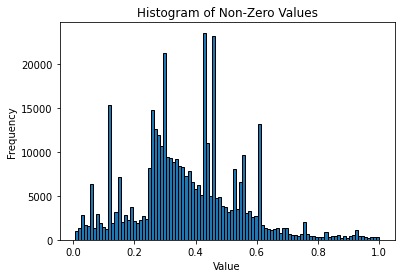

In [285]:
# Flatten DataFrame values to 1D array
all_values = harmonized_open_targets.values.flatten()

# Count zeros and non-zeros
total_values = len(all_values)
zero_count = np.count_nonzero(all_values == 0)
non_zero_values = all_values[all_values != 0]

# Calculate percentage of zeros
zero_percentage = (zero_count / total_values) * 100
print(f"Percentage of zeros: {zero_percentage:.2f}%")

# Plot histogram of non-zero values
plt.hist(non_zero_values, bins=100, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Non-Zero Values')
plt.show()

# Merge with hospital data

In [286]:
diag_df = pd.read_csv('data/Diagnosis_global_10years.csv')  # Read diagnosis metadata  DiagAll_Eng.csv
diag_df = diag_df[diag_df['age_id'] < 9].iloc[:1080, :]
# Add an 'ID' column to diag_df starting from 0 up to the number of rows in diag_df
diag_df['ID'] = range(0, len(diag_df))
diag_df.loc[:, 'English description'] = [icd10.find(x[0]).description if icd10.find(x[0]) else x[1] for x in diag_df[['icd_code', 'descr']].values ]
diag_df.loc[:, 'icd_global'] = diag_df['icd_global'].str.replace('__', '-')
diag_df

,Unnamed: 0,diagnose_id,icd_code,descr,postion,age_id,age_range,icd_global,ID,English description
0,1,1,A00,Cholera,1,1,0-9,A00-0-9,0,Cholera
1,2,2,A01,Typhus abdominalis und Paratyphus,2,1,0-9,A01-0-9,1,Typhoid and paratyphoid fevers
2,3,3,A02,Sonstige Salmonelleninfektionen,3,1,0-9,A02-0-9,2,Other salmonella infections
3,4,4,A03,Shigellose [Bakterielle Ruhr],4,1,0-9,A03-0-9,3,Shigellosis
4,5,5,A04,Sonstige bakterielle Darminfektionen,5,1,0-9,A04-0-9,4,Other bacterial intestinal infections
...,...,...,...,...,...,...,...,...,...,...
1075,1076,1070,N95,Klimakterische Störungen,1076,1,0-9,N95-0-9,1075,Menopausal and other perimenopausal disorders
1076,1077,1071,N96,"Neigung zu habituellem Abort, Infertilität, Untersuchung oder Betreuung einer Frau mit Neigung zu habituellem Abort ohne bestehende Schwangerschaft",1077,1,0-9,N96-0-9,1076,Recurrent pregnancy loss
1077,1078,1072,N97,Sterilität der Frau,1078,1,0-9,N97-0-9,1077,Female infertility
1078,1079,1073,N98,Komplikationen im Zusammenhang mit künstlicher Befruchtung,1079,1,0-9,N98-0-9,1078,Complications associated with artificial fertilization


In [287]:
open_target_df = pd.read_csv(harmonized_fname.replace('.csv', '_icd.csv'))
open_target_df.index = open_target_df.columns
# open_target_df = (open_target_df > 0).astype(int)
display(open_target_df)

,E30,E45,N86,E40,F62,B38,I83,N64,K10,N19,...,B79,K40,I22,A37,G58,J02,H66,M07,A75,K61
E30,0.000000,0.0,0.0,0.266274,0.0,0.00000,0.0,0.000000,0.0,0.000000,...,0.359545,0.190162,0.000000,0.000000,0.000000,0.000000,0.000000,0.301129,0.000000,0.000000
E45,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.000000,...,0.274238,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
N86,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
E40,0.266274,0.0,0.0,0.000000,0.0,0.00000,0.0,0.234865,0.0,0.000000,...,0.285006,0.361944,0.280195,0.000000,0.264085,0.000000,0.092184,0.283357,0.303297,0.179931
F62,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
J02,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.455948,...,0.346551,0.112625,0.531939,0.405527,0.399718,0.334362,0.000000,0.000000,0.000000,0.000000
H66,0.000000,0.0,0.0,0.092184,0.0,0.00000,0.0,0.000000,0.0,0.000000,...,0.255939,0.000000,0.000000,0.000000,0.000000,0.000000,0.500488,0.152830,0.000000,0.000000
M07,0.301129,0.0,0.0,0.283357,0.0,0.26367,0.0,0.060793,0.0,0.000000,...,0.300715,0.257641,0.000000,0.000000,0.000000,0.000000,0.152830,0.607931,0.269192,0.000000
A75,0.000000,0.0,0.0,0.303297,0.0,0.00000,0.0,0.000000,0.0,0.000000,...,0.282384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.269192,0.531939,0.000000


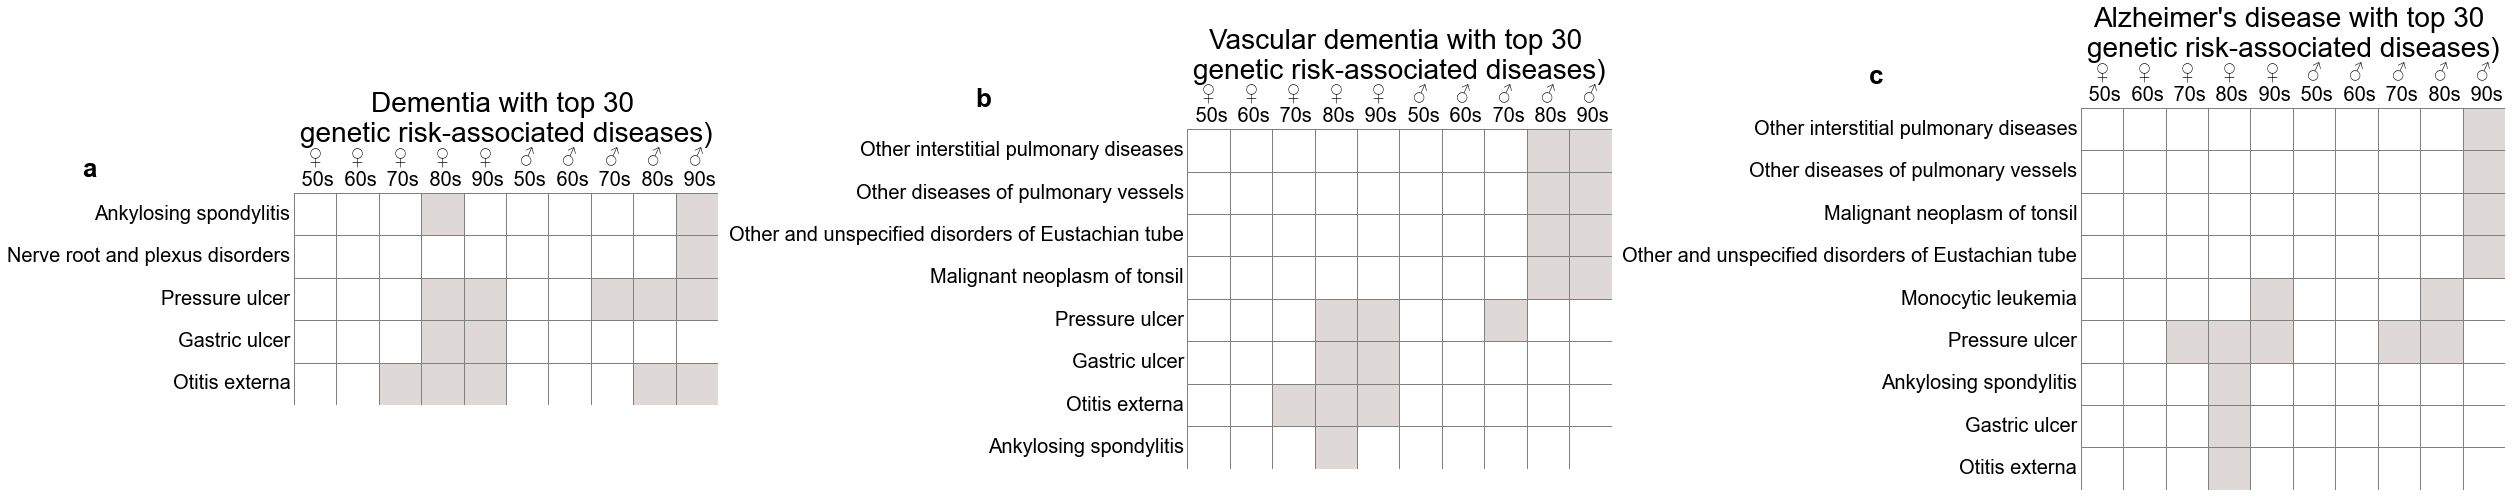

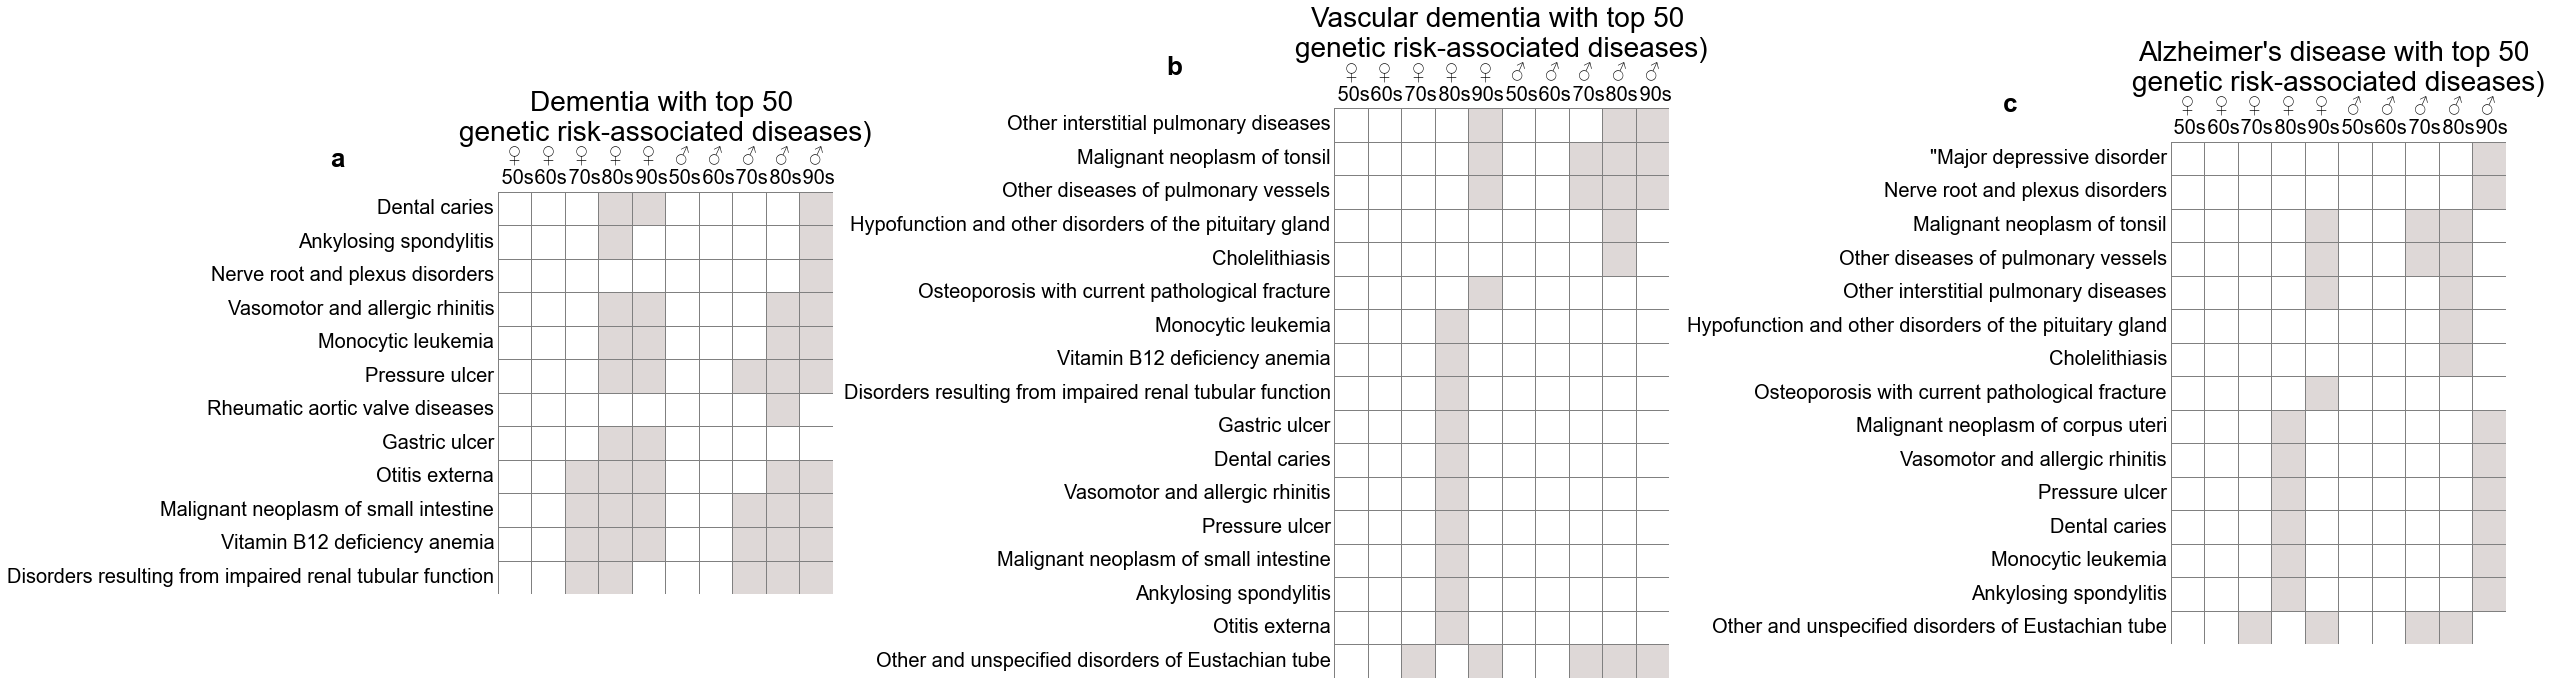

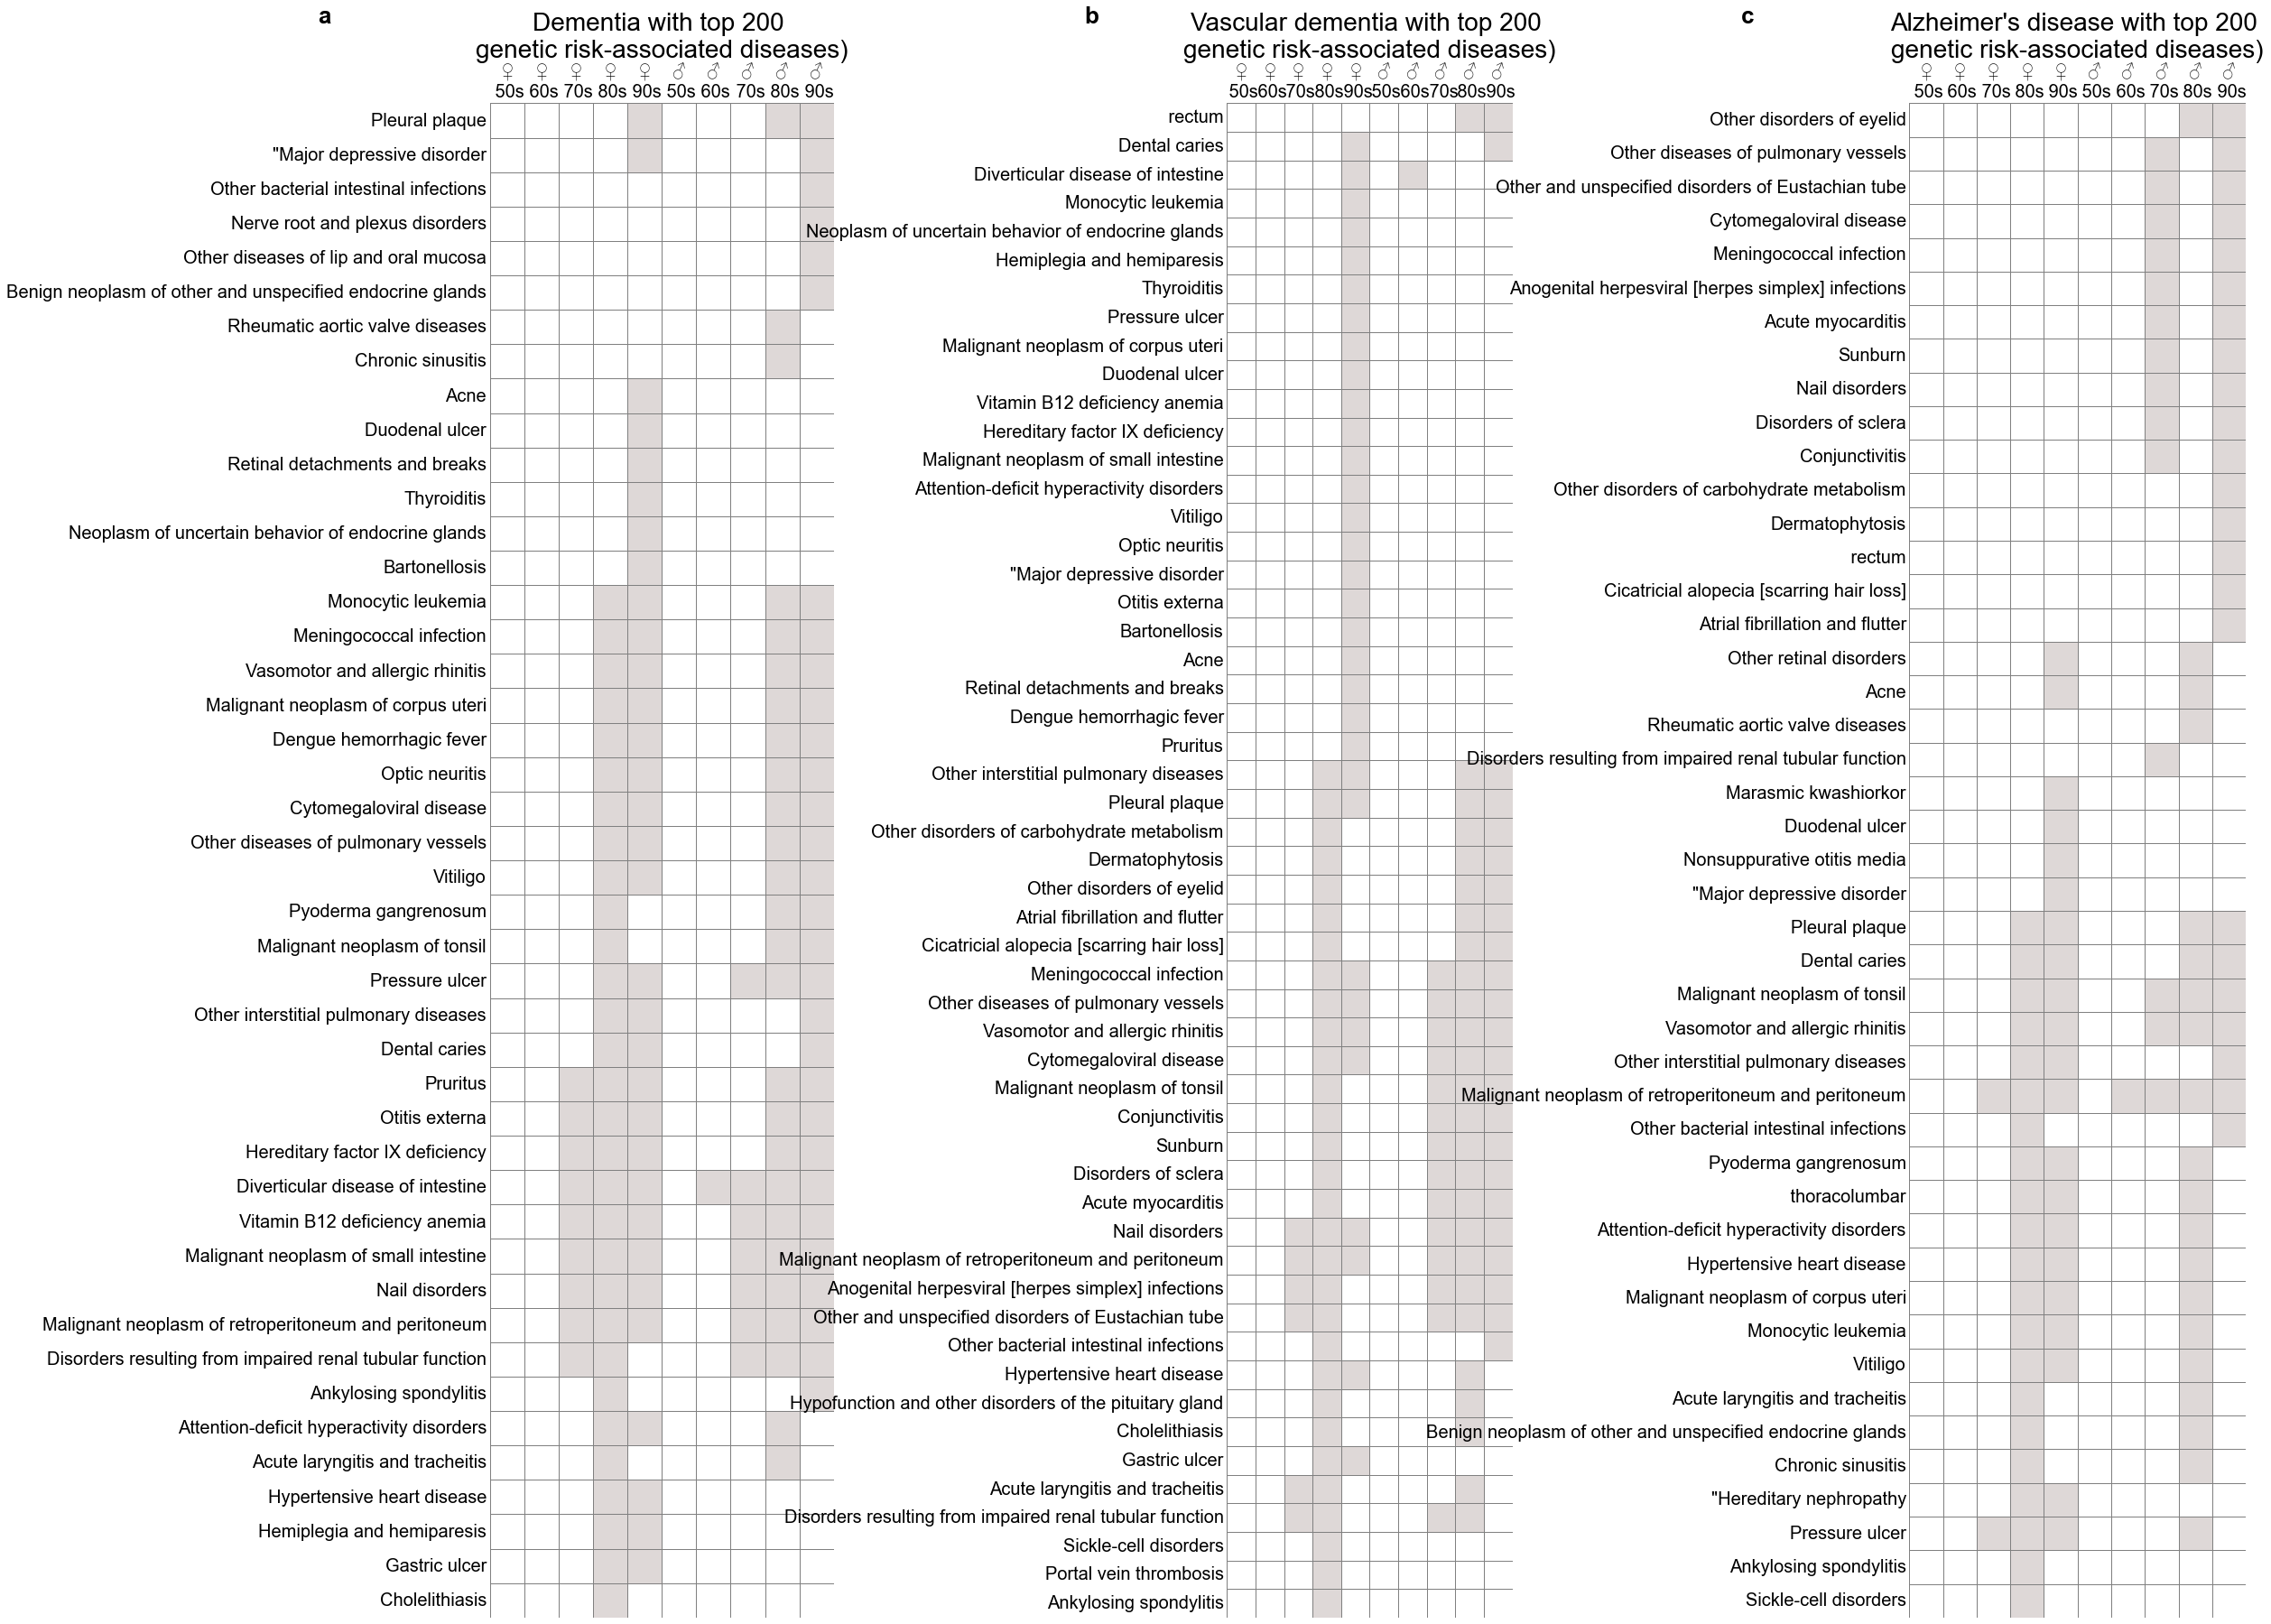

In [327]:
dementia_codes = {'F00': 'Dementia', #'Dementia in Alzheimer\'s disease'
                  'F01': 'Vascular dementia',
                  'F02': 'Dementia in other diseases classified elsewhere',
                  'F03': 'Unspecified dementia',
                  'G30': 'Alzheimer\'s disease'}

with open(harmonized_fname, 'r') as f:
    disease_names = f.readline().strip().split(',')
rds_files = glob.glob("data/dementia_age_groups/*.rds")


for TOP_K in [30, 50, 200]:
    df_out = pd.DataFrame(columns=['Graph', 'ICD10', 'Pearson', 'p-val', 'Correlated disease', 'Num correlated diseases'])
    ind = 0
    fig, axes = plt.subplots(1, 3, figsize=(35, 25))  # 3 columns, 1 row
    for i, code in enumerate(['F00', 'F01', 'G30']):
        if code in df.index:

            for f in rds_files:
                result = pyreadr.read_r(f) # also works for RData
                # result is a dictionary where keys are the name of objects and the values python
                df = result[None] # extract the pandas data frame 
                # dfs[gender].columns = [str(col) for col in df.columns]
                df.fillna(0, inplace=True)
                df.columns = diag_df['icd_code']
                df.index = diag_df['icd_code']
                df = df.loc[df.index.isin(open_target_df.index), df.columns.isin(open_target_df.columns)]
            #     print('MAX:', np.max(np.max(df)))
            #     print('MIN:', np.min(np.min(df)))



                row1 = open_target_df.loc[code]
                row2 = df.loc[code]

    #             corr, pval = pearsonr(row1, row2)

                # Get the indices of the TOP_K largest elements in row1
                top_indices = np.argpartition(row1.values, -TOP_K)[-TOP_K:]
                # Sort those indices by the actual values (optional, to have sorted results)
                top_indices = top_indices[np.argsort(-row1.values[top_indices])]
                top_disease_names = np.array(disease_names)[top_indices]

                # Extract subsets
                row1_subset = row1.values[top_indices]
                row2_subset = row2.values[top_indices]
                try:
                    correlated_diseases = top_disease_names[np.nonzero(row2_subset)[0]]
                except TypeError as e:
                    correlated_diseases = [] 


                # Compute Pearson correlation coefficient and p-value
                if np.std(row1_subset) == 0. or np.std(row2_subset) == 0.:
    #                 print("Pearson correlation undefined for constant input.")
                    corr, pval = np.nan, np.nan
                else:
                    corr, pval = pearsonr(row1_subset, row2_subset)

    #             print(f.split('/')[-1].split('.')[0].replace('All_OR_', ''), f"{code}, {correlated_diseases}")
                df_out.loc[ind] = [f.split('/')[-1].split('.')[0].replace('All_OR_', ''), code, corr, pval, correlated_diseases, len(correlated_diseases)]
                ind+=1
        df_sorted = df_out.sort_values(by='Pearson', key=lambda x: x.abs(), ascending=False)
        # df_sorted.to_csv('hospital_gene_correlations_pearson_binary.csv', index=False)
        pd.set_option('display.max_colwidth', None)
        gr_dis_dict = dict(zip(df_sorted['Graph'], df_sorted['Correlated disease']))
        gr_dis_dict

        dis_gr_dict = dict()
        for graph, dis in gr_dis_dict.items():
            for d in dis:
                if d in dis_gr_dict.keys():
                    dis_gr_dict[d].append(graph)
                else:
                    dis_gr_dict[d] = [graph]
        dis_gr_df = pd.DataFrame({(k, ','.join(v)) for k, v in dis_gr_dict.items()}, columns=['Disease', 'Detected in'])
        for gr in sorted(gr_dis_dict.keys()):
            dis_gr_df.loc[:, gr.replace('_Age_', ' ') + '0s'] = dis_gr_df['Detected in'].apply(lambda x: 1 if gr in x else 0)
        dis_gr_df.rename(columns={'Disease': dementia_codes[code]}, inplace=True)

        dis_gr_df = dis_gr_df.sort_values(by='Detected in', ascending=False)
        dis_gr_df = dis_gr_df.drop(columns=['Detected in'])
        dis_gr_df.set_index(dementia_codes[code], inplace=True)


        # Modify column and index labels to replace "Female" and "Male" with symbols
        dis_gr_df.columns = [label.replace("Female", "♀\n").replace("Male", "♂\n") for label in dis_gr_df.columns]
        dis_gr_df.index = [label.replace("Female", "♀\n").replace("Male", "♂\n") for label in dis_gr_df.index]

        # Set font to Arial
        plt.rcParams["font.family"] = "Arial"

        # Custom colormap
        cmap = sns.color_palette(["white", "#ded8d7"])

        # Plot heatmap
        ax = sns.heatmap(dis_gr_df, cmap=cmap, cbar=False, linewidths=0.5, linecolor='gray', square=True, ax=axes[i])

        # Move x-axis labels to the top
        ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_label_position('top')

        # Make x-axis labels horizontal and increase font sizes
        ax.tick_params(axis='x', labelrotation=0, labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        ax.tick_params(axis='both', which='both', length=0) # Remove tick marks
        ax.set_title(f'{dementia_codes[code]} with top {TOP_K} \ngenetic risk-associated diseases)', size=28)
        # Add subplot letter labels (a, b, c...)
        label = chr(97 + i)  # 'a' for 0, 'b' for 1, etc.
        ax.text(-0.5, 1.05, f'{label}', transform=ax.transAxes,
                fontsize=26, fontweight='bold', va='bottom', ha='left')

    # Adjust layout and save to PDF
    plt.tight_layout()
    plt.savefig(f"dementia_heatmaps_{TOP_K}.pdf", dpi=200, format='pdf', bbox_inches='tight')
    plt.show()

In [328]:
row1_subset

array([0.99473739, 0.98341496, 0.97581435, 0.95141306, 0.94741417,
       0.94177487, 0.9402794 , 0.92208086, 0.9180229 , 0.9176432 ,
       0.91742769, 0.91567463, 0.91473246, 0.91136025, 0.90648098,
       0.89668344, 0.89522541, 0.89163074, 0.89050908, 0.88684141,
       0.88500876, 0.88475705, 0.87434957, 0.87434957, 0.87370408,
       0.86627606, 0.86545704, 0.86545704, 0.86545704, 0.86545704,
       0.86515343, 0.86515343, 0.86501601, 0.8559741 , 0.85577904,
       0.85475644, 0.84857512, 0.84836135, 0.84836135, 0.84521244,
       0.8448599 , 0.84483944, 0.8443168 , 0.84395251, 0.84387283,
       0.84205505, 0.84109614, 0.83816152, 0.83708438, 0.83134278,
       0.83031867, 0.83021457, 0.82825476, 0.82746136, 0.82739809,
       0.82721367, 0.82721367, 0.8235943 , 0.81732117, 0.81307956,
       0.80334704, 0.79622048, 0.79047837, 0.79009818, 0.78128163,
       0.78098159, 0.77891133, 0.77630863, 0.77496267, 0.77496267,
       0.76819016, 0.76709046, 0.761328  , 0.7599135 , 0.75991

In [325]:
row2_subset

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  3.02771537,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

Percentage of zeros: 96.78%


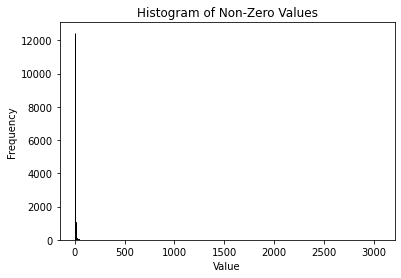

In [258]:
# Flatten DataFrame values to 1D array
all_values = df.values.flatten()

# Count zeros and non-zeros
total_values = len(all_values)
zero_count = np.count_nonzero(all_values == 0)
non_zero_values = all_values[all_values != 0]

# Calculate percentage of zeros
zero_percentage = (zero_count / total_values) * 100
print(f"Percentage of zeros: {zero_percentage:.2f}%")

# Plot histogram of non-zero values
plt.hist(non_zero_values, bins=1400, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Non-Zero Values')
plt.show()